# Imports

In [83]:
import pandas as pd 
import json
import os
import numpy as np
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import punkt
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix
import string
from nltk.probability import FreqDist
import seaborn as sns
pd.options.display.max_rows = 999
pd.options.display.max_columns = 30
import src
from src import *
import importlib
importlib.reload(src)
import lexnlp as lnlp
%matplotlib inline

In [106]:
df2 = pd.read_csv("data/SCDB_2020_01_caseCentered_Citation.csv",encoding='cp1252' )

In [22]:
df2 = df2[df2.majVotes < 7]

In [120]:
plt.style.use(['fivethirtyeight'])
plt.style.use(['seaborn-poster'])

In [121]:
df2.decisionDirection.value_counts()

2.0    4534
1.0    4302
3.0     155
Name: decisionDirection, dtype: int64

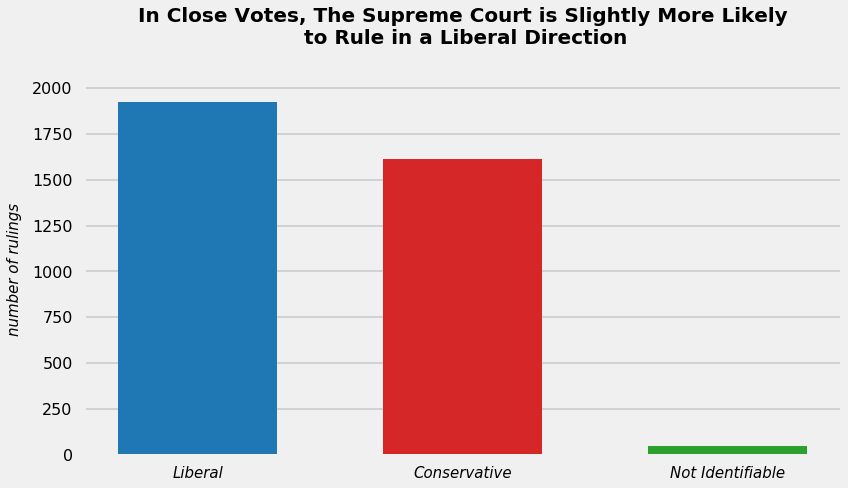

In [140]:
plt.figure(figsize = (12, 7))
colors = ('tab:blue', 'tab:red', 'tab:green')
outcome = ['Liberal', 'Conservative', 'Not Identifiable']
count = [1926, 1614, 47]
plt.bar(outcome, count, color= colors, width =.6 )
plt.title('In Close Votes, The Supreme Court is Slightly More Likely\n to Rule in a Liberal Direction', 
          fontweight ='bold', size =20, pad = 40, loc = 'center')
plt.ylabel("number of rulings", size = 15, labelpad = 10, style = 'italic')
plt.xticks(style = 'italic', size = 15)
plt.grid(axis = 'x')
plt.tight_layout()
plt.savefig("outcome_direction.png")

Since 1946 in close cases *(6 or less votes in the majority)* the Supreme Court has been more likely to rule in a liberal direction, liberal, conservative and not identifiable are defined in the  2020 Supreme Court [codebook](http://scdb.wustl.edu/documentation.php?var=decisionDirection) where this data was obtained.

In [123]:
df2.partyWinning.value_counts()/len(df2)

1.0    0.638427
0.0    0.359247
2.0    0.000554
Name: partyWinning, dtype: float64

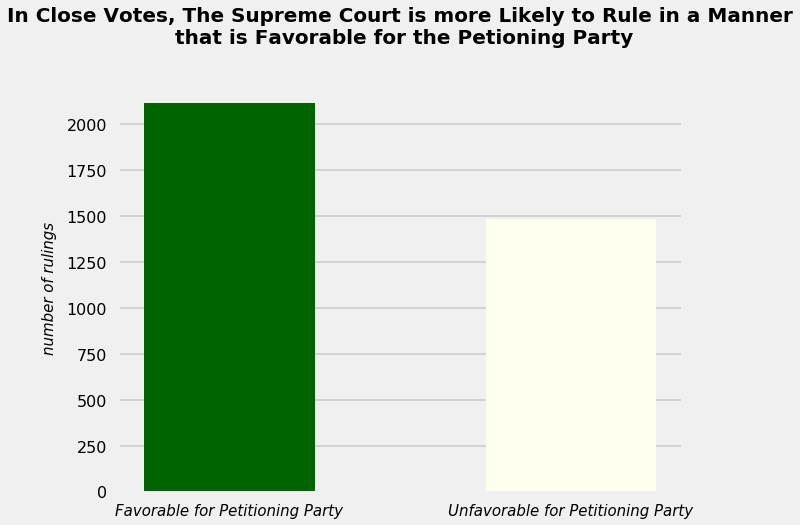

In [137]:
plt.figure(figsize = (9, 7))
outcome = ['Favorable for Petitioning Party', 'Unfavorable for Petitioning Party']
count = [2116, 1486]
colors2 = ('darkgreen', 'ivory')
plt.bar(outcome, count, color = colors2, width = .5)
plt.title('In Close Votes, The Supreme Court is more Likely to Rule in a Manner\n that is Favorable for the Petioning Party', 
          fontweight ='bold', size = 20, pad = 40, loc = 'center')
plt.ylabel("number of rulings", size = 15, labelpad = 10, style = 'italic')
plt.xticks(style = 'italic', size = 15)
plt.grid(axis = 'x')
fig.tight_layout()
plt.savefig('petitioner.png')

Since 1946 in close cases, the petitioner is more likely to recieve a favorable opinion. Note that this does not neccesarily mean they outright 'won' the case, this variable is further documented [here.](http://scdb.wustl.edu/documentation.php?var=partyWinning)This means that the Supreme Court is more likely to overturn lower court decisions than uphold them. Since my target variable is whether the the petitioning party wins this relationship represents a class imbalance in my data. 

In [125]:
df2[df2['partyWinning'] == 0]['decisionDirection'].value_counts()

1.0    1819
2.0    1318
3.0      85
Name: decisionDirection, dtype: int64

In [126]:
df2[df2['partyWinning'] == 1]['decisionDirection'].value_counts()

2.0    3216
1.0    2482
3.0      67
Name: decisionDirection, dtype: int64

In [127]:
countL = [894, 546, 30]
countW = [1068, 1032, 16]
sumL = 894+546+30
sumW = 1068 + 1032 +16
perL = [x/sumL for x in countL]
perW = [x/sumW for x in countW]
outcome = ['Liberal', 'Conservative', 'Not Identifiable']

x = np.arange(len(outcome))


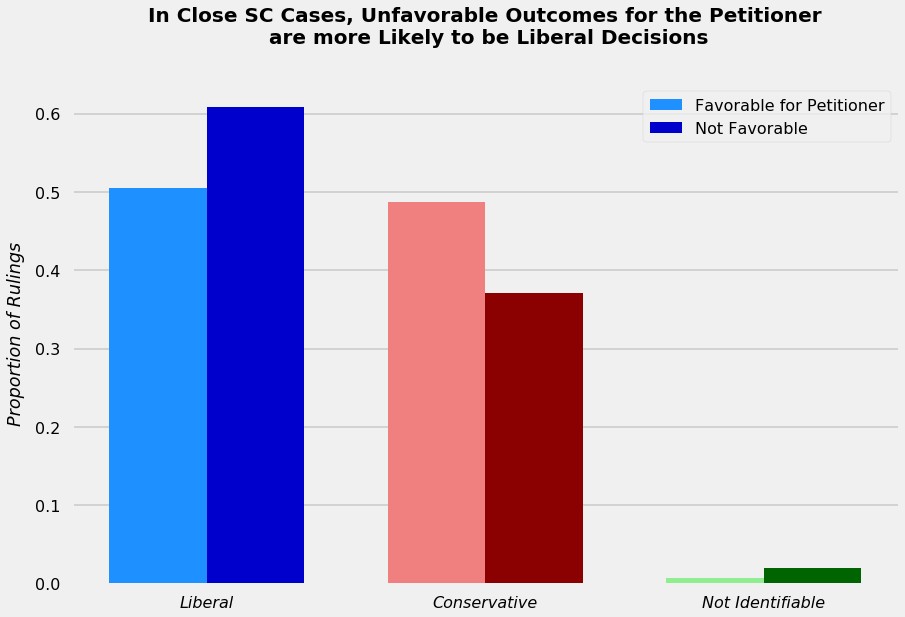

<Figure size 921.6x633.6 with 0 Axes>

In [135]:

labels = ['Liberal', 'Conservative', 'Not Identifiable']
men_means = countW
women_means = countL
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
colorsw = ['dodgerblue','lightcoral', 'lightgreen']
colorsl= ['mediumblue', 'darkred', 'darkgreen']
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, perW, width, label='Favorable for Petitioner', color = colorsw)
rects2 = ax.bar(x + width/2, perL, width, label='Not Favorable', color = colorsl)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Proportion of Rulings', style = 'italic', labelpad = 10)
ax.set_title('''In Close SC Cases, Unfavorable Outcomes for the Petitioner\n are more Likely to be Liberal Decisions''',
             fontweight ='bold', size = 20, pad = 40, loc = 'center')
ax.set_xticks(x)
ax.set_xticklabels(labels, style = 'italic')
ax.legend()
plt.grid(axis = 'x')
fig.tight_layout()
plt.show()
plt.savefig('scdisposition.png')

This graphic shows that the SC is about equally as likely to rule in liberal or conservative direction when ruling in favor of the petitioner but more likely to rule in a liberal direction when ruling in a manner not favorable for the petitioner. Essentially, the Court is more likely to uphold decisions by lower courts that were liberal. Unfortunately I cannot predict on that so lets see if this relationship holds for the decision direction of the lower court.

In [129]:
df2[df2['partyWinning'] == 0]['lcDispositionDirection'].value_counts()

1.0    1763
2.0    1323
3.0      62
Name: lcDispositionDirection, dtype: int64

In [130]:
df2[df2['partyWinning'] == 1]['lcDispositionDirection'].value_counts()

1.0    3149
2.0    2490
3.0      32
Name: lcDispositionDirection, dtype: int64

In [131]:
countLl = [879, 543, 35]
countWl = [1054, 1026, 10]

perLl = [x/sum(countLl) for x in countLl]
perWl = [x/sum(countWl) for x in countWl]

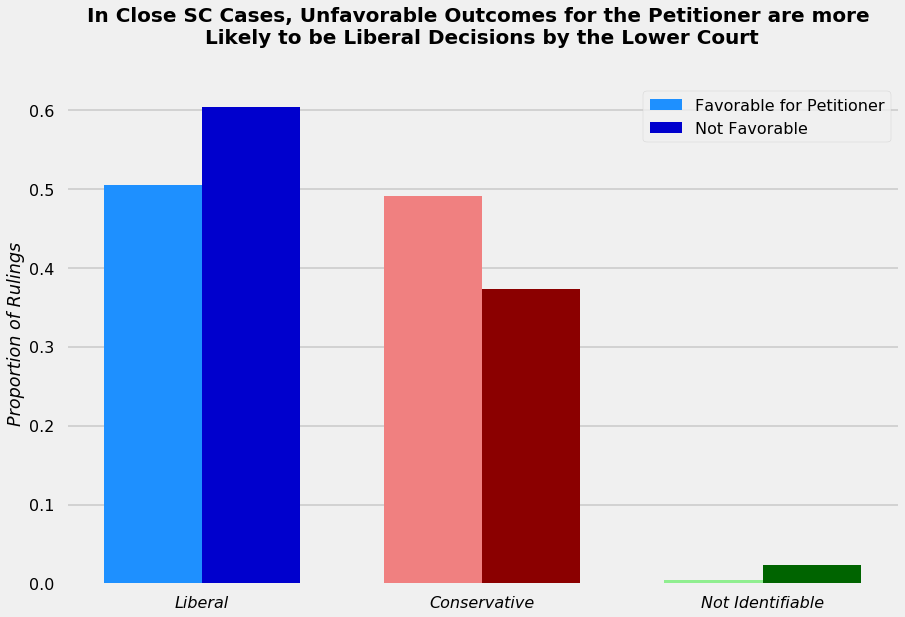

In [134]:

labels = ['Liberal', 'Conservative', 'Not Identifiable']
liberal = countWl
liberal = countLl
x = np.arange(len(labels))  
width = 0.35  
colorsw = ['dodgerblue','lightcoral', 'lightgreen']
colorsl= ['mediumblue', 'darkred', 'darkgreen']
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, perWl, width, label='Favorable for Petitioner', color = colorsw)
rects2 = ax.bar(x + width/2, perLl, width, label='Not Favorable', color = colorsl)
ax.set_ylabel('Proportion of Rulings', style = 'italic')
ax.set_title('''In Close SC Cases, Unfavorable Outcomes for the Petitioner are more \nLikely to be Liberal Decisions by the Lower Court''',
             fontweight ='bold', size = 20, pad = 40, loc = 'center')
ax.set_xticks(x)
ax.set_xticklabels(labels, style = 'italic')
ax.legend()
plt.grid(axis = 'x')
fig.tight_layout()
plt.savefig('lcdisposition.png')

This graphic further shows this relationship. When the Lower Court rules in a liberal direction it is less likely the petitioner will be succesful.

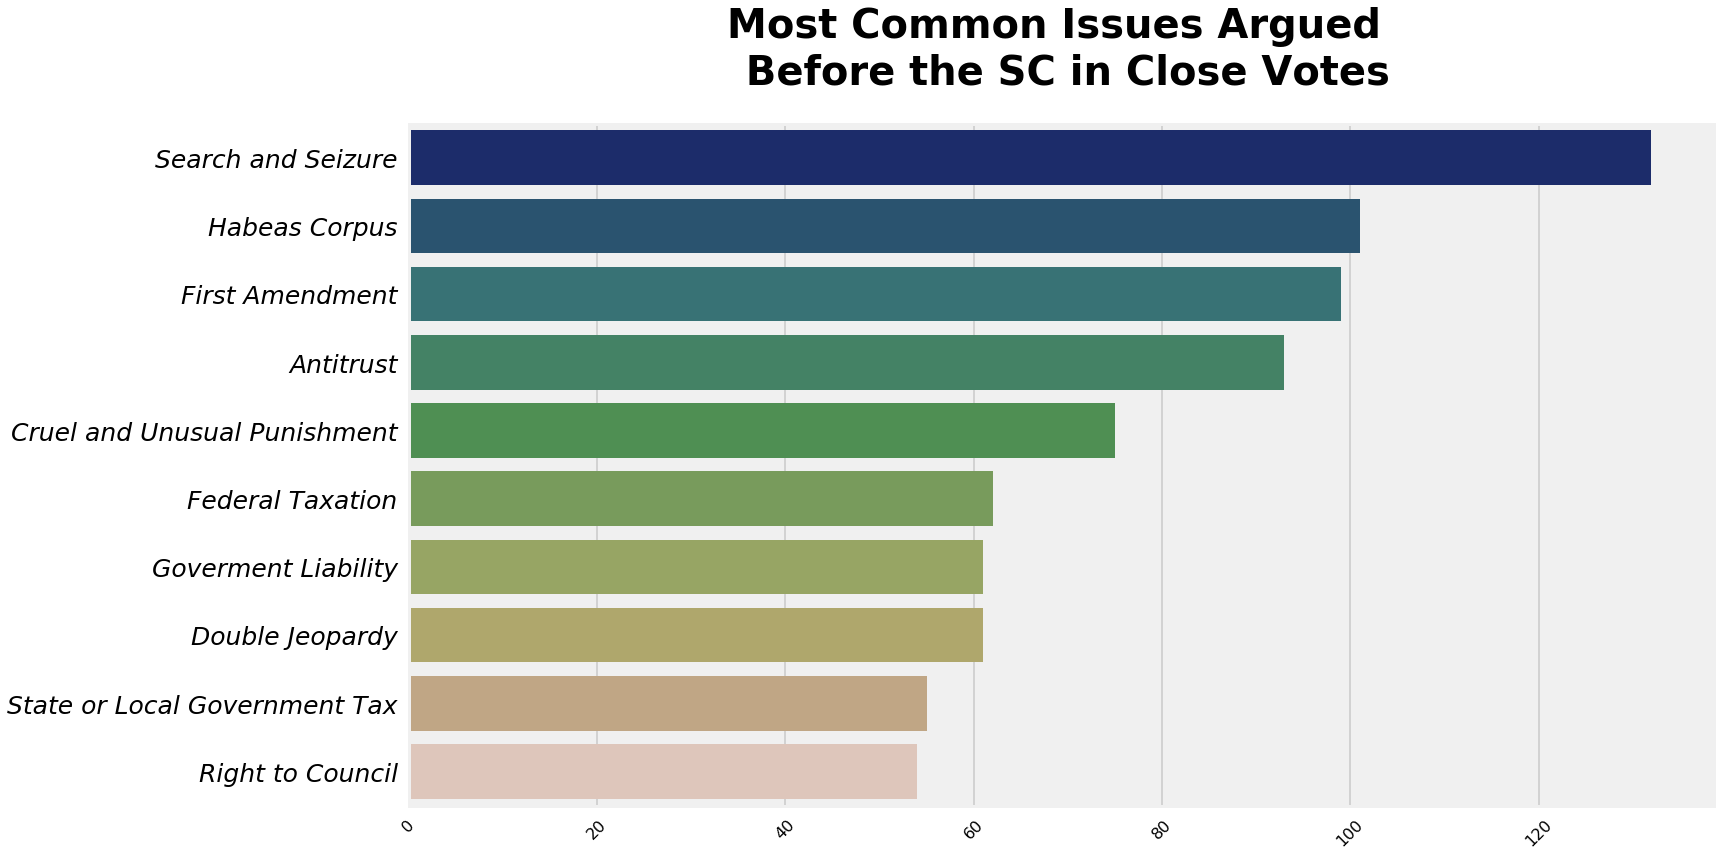

In [110]:

fig = plt.figure(figsize= (24, 12))
ax = fig.add_subplot(111)
count = [132, 101, 99, 93, 75, 62, 61, 61, 55, 54]
labels = ['Search and Seizure', 'Habeas Corpus','First Amendment' ,'Antitrust', 'Cruel and Unusual Punishment', 'Federal Taxation', 'Goverment Liability', 'Double Jeopardy', 
          'State or Local Government Tax', 'Right to Council']
dfg = pd.DataFrame(count, labels)
sns.barplot(count, labels, data = dfg, palette = 'gist_earth' )
ax.set_title('Most Common Issues Argued \n Before the SC in Close Votes', size = 40, fontweight = 'bold',pad = 40, loc= 'center')
plt.xticks(rotation = 45)
plt.yticks(size = 25, fontstyle = 'italic')
fig.set_tight_layout(True)
plt.savefig("common_issues.png")

These are the 10 issues that are argued before the SC in close cases, Search and Seizure is the most common by a large margin. 

In [37]:
df2[df2.partyWinning == 0]['issue'].value_counts().head(10)

10050.0     44
80010.0     41
10130.0     33
10170.0     32
80100.0     31
30010.0     31
120010.0    30
10020.0     28
10120.0     27
80060.0     24
Name: issue, dtype: int64

In [38]:
countL = [44, 41, 33, 32, 31, 31, 30, 28, 27, 24]
labelsL = ['Search and Seizure', 'Antitrust','Cruel and Unusual Punishment', 'Double Jeopardy', 'State or Local Government Tax',
          'First Amendment', 'Federal Taxation', 'Habeas Corpus', 'Right to Council', 'Government Liability']
preL = [x/sum(countL) for x in countL]
dfg2 = pd.DataFrame(countL, labelsL)

In [39]:
df2[df2.partyWinning == 1]['issue'].value_counts().head(10)

10050.0    88
10020.0    73
30010.0    68
80010.0    52
10130.0    42
80060.0    37
80040.0    37
80070.0    36
20400.0    34
90120.0    33
Name: issue, dtype: int64

In [40]:

countW = [88, 73, 68, 52, 42, 37, 37, 36, 34, 33]
preW = [x/sum(countW) for x in countW]
labelsW = ['Search and Seizure', 'Habeas Corpus', 'First Amendment', 'Antitrust', 'Cruel and Unusual Punishment', 
          'Government Liability', 'Sufficiency of Evidence', 'Liability', 'Liability; Civil Rights Act', 'Judicial Review of Adminstrative Processes']
dfgW = pd.DataFrame(countW, labelsW)


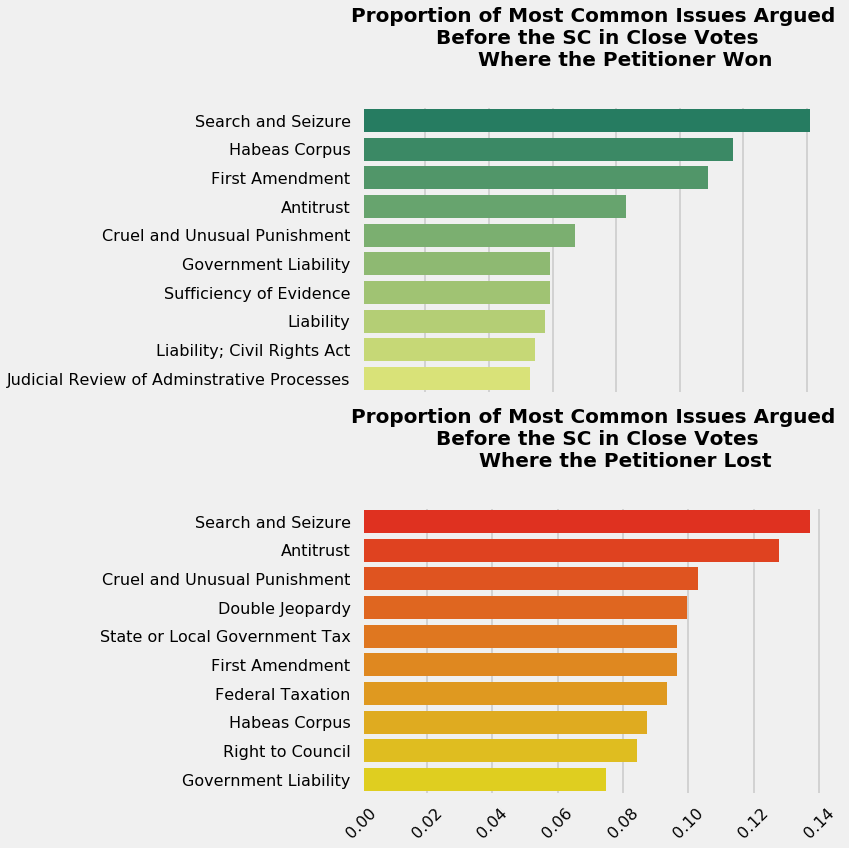

In [41]:
fig, axarr = plt.subplots(2, 1, figsize=(12, 12))
axarr[0].set_xticklabels(labels = '', rotate = 45)
sns.barplot(preW, labelsW, data = dfg, palette = 'summer', ax = axarr[0])

axarr[0].set_title("""Proportion of Most Common Issues Argued \n Before the SC in Close Votes 
        Where the Petitioner Won""", size = 20, fontweight = 'bold',pad = 40, loc= 'center')

sns.barplot(preL, labelsL, data = dfg2, palette = 'autumn', ax = axarr[1])

axarr[1].set_title("""Proportion of Most Common Issues Argued \n Before the SC in Close Votes 
        Where the Petitioner Lost""", size = 20, fontweight = 'bold', pad = 40, loc = 'center')
plt.subplots_adjust( hspace = .70)
fig.set_tight_layout(True)
plt.xticks(rotation = 45)
plt.savefig('Common-issues.png')


These are the top ten issues argueed before the Supreme Court when the petioner recieved a favorable and outcome and when they did not. It seems petitioners do worse in Antitrust cases, double jeopardy cases right to council and federal taxation cases. The petitioner seemingly does better in Habeas Corpus, sufficiency of evidence, liability, Civil Rights Act liability and judicial review of administrative proccesses cases. 

## Text EDA

In [107]:
final_df = pd.read_csv("data/Final Merge.csv")

In [43]:
final_df.head()

,Unnamed: 0,case,text,target,lib_or_con,majVotes
0,0,352us282,may it please the court this case be here on a...,1,2.0,6
1,1,353us586,mr chief justice if the court please when the ...,1,2.0,4
2,5,352us249,if the court please you might wait just a mome...,0,2.0,5
3,9,354us147,mr chief justice if the court please this be a...,0,2.0,5
4,10,352us407,mr chief justice may it please the court this ...,1,1.0,6


### Most Common Words

First lets take a look at the most common words found in all cases. 

In [44]:
wordsls = list(map(src.process_article, final_df.text))

wordsls = [item for sublist in wordsls for item in sublist]

freq_dis = FreqDist(wordsls)

words_df = pd.DataFrame(freq_dis.most_common())

words_df.columns = ('word', 'count')





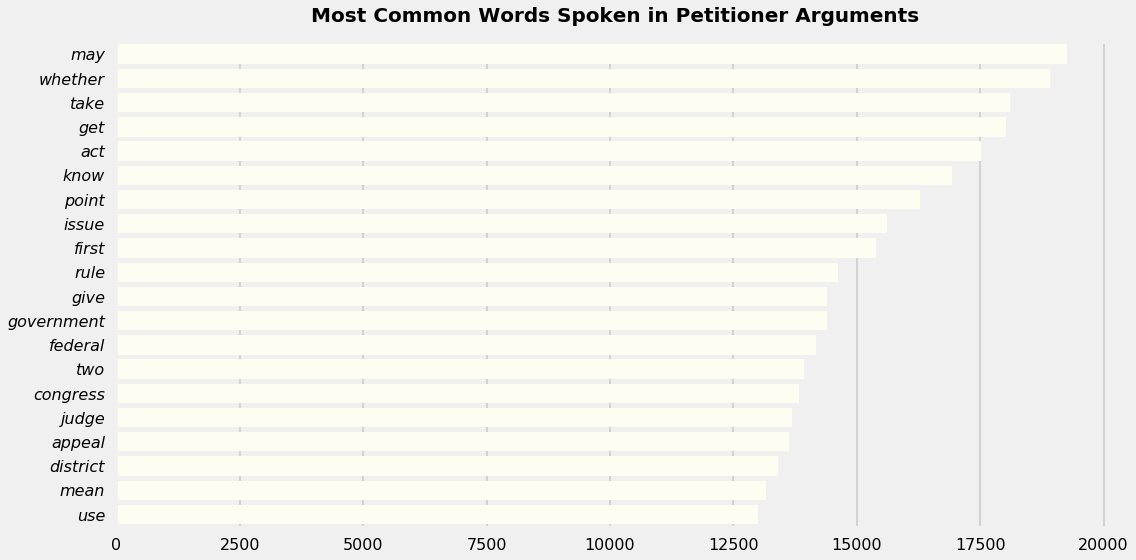

In [146]:
fig, ax = plt.subplots(1, 1, figsize = (16, 8))

sns.barplot('count', 'word', data = words_df.head(20), ax = ax, palette = ['ivory'])

ax.set_title('Most Common Words Spoken in Petitioner Arguments',  size = 20, fontweight = 'bold',pad = 20, loc= 'center')

fig.set_tight_layout(True)

ax.set_ylabel('')
ax.set_xlabel('')
plt.tight_layout
ax.set_yticklabels(labels = words_df.word[0:20], style= 'italic', )
plt.savefig("most_common.png")

There are no surprises here, If you had asked me before this project what the most common words used in legal arguments were, it might look alot like this list. I don't know what we are paying lawyers so much for, theres not even any latin!

In [78]:
legalstops = list(words_df.word[0:20])
legalstops

['may',
 'whether',
 'take',
 'get',
 'act',
 'know',
 'point',
 'issue',
 'first',
 'rule',
 'give',
 'government',
 'federal',
 'two',
 'congress',
 'judge',
 'appeal',
 'district',
 'mean',
 'use']

These words were also the most common in both the clasees, so I decided to use them as stopwords since they tell us very little and are uninteresting in general.

### Most Common Words Winning

In [84]:
winning = final_df[final_df.target == 1]['text']

wordsls2 = list(map(src.process_article2, winning))
                    
wordsls2 = [item for sublist in wordsls2 for item in sublist]

freq_dis2 = FreqDist(wordsls2)

words_df2 = pd.DataFrame(freq_dis2.most_common())

words_df2.columns = ('word', 'count')



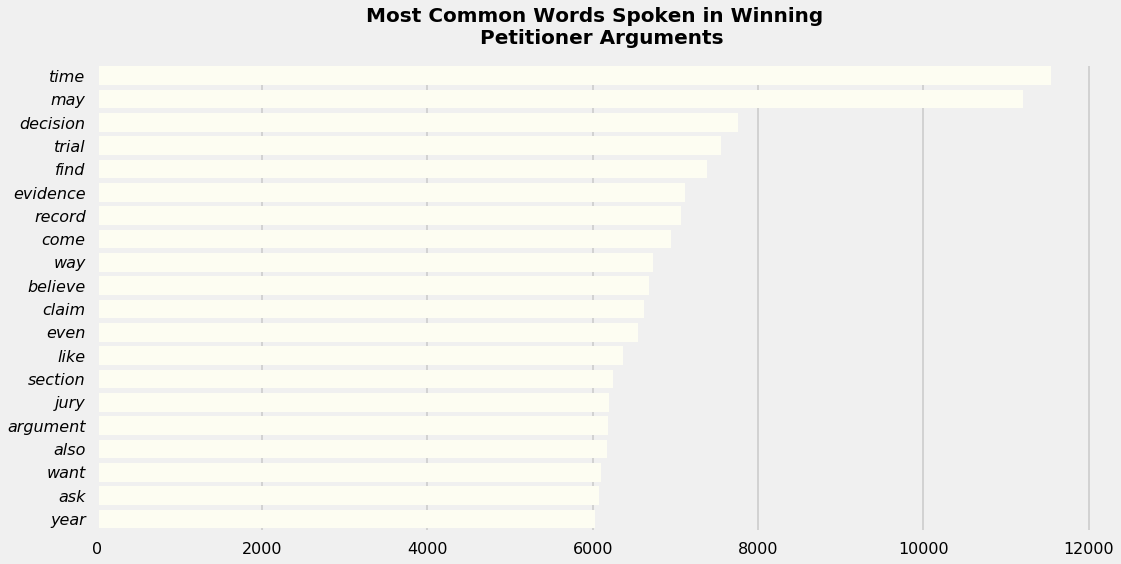

In [145]:
fig, ax = plt.subplots(1, 1, figsize = (16, 8))
sns.barplot('count', 'word', data = words_df2.head(20), ax = ax, palette = ['ivory'])
ax.set_title('Most Common Words Spoken in Winning \n Petitioner Arguments',  size = 20, fontweight = 'bold',pad = 20, loc= 'center')
plt.tight_layout
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_yticklabels(labels = words_df2.word[0:20], style= 'italic', )
plt.savefig("winning.png")

More generally boring words and legalese, lets see if theres any differences with losing arguments.

### Most Common Words Losing

In [97]:
losing = final_df[final_df.target == 0]['text']

wordsls3 = list(map(src.process_article2, losing))
                    
wordsls3 = [item for sublist in wordsls3 for item in sublist]

freq_dis3 = FreqDist(wordsls3)

words_df3 = pd.DataFrame(freq_dis3.most_common())

words_df3.columns = ('word', 'count')




In [98]:
top15W = list(words_df2.word[0:20])
top15L = list(words_df3.word[0:20])
colors_dif = []

for x in range(0,20):
    if top15L[x] not in top15W:
        colors_dif.append('tab:red')
    elif top15W[x] == top15L[x]:
        colors_dif.append('ivory')
    else:
         colors_dif.append('tan')


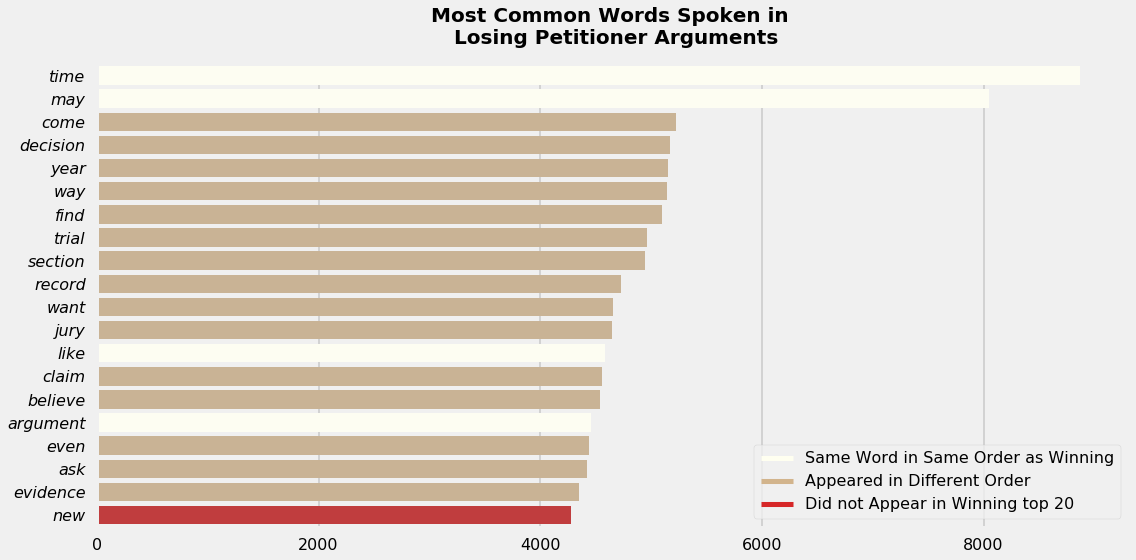

In [144]:
fig, ax = plt.subplots(1, 1, figsize = (16, 8))
sns.barplot('count', 'word', data = words_df3.head(20), palette = colors_dif, ax = ax)
ax.set_title('Most Common Words Spoken in \n Losing Petitioner Arguments',  size = 20, fontweight = 'bold', pad = 20, loc= 'center')
ax.set_yticklabels(labels = words_df3.word[0:20], style= 'italic', );
ax.set_ylabel('')
ax.set_xlabel("")
ax.legend(['Same Word in Same Order as Winning', 'Appeared in Different Order', "Did not Appear in Winning top 20"])
leg = ax.get_legend()
leg.legendHandles[0].set_color('ivory')
leg.legendHandles[1].set_color('tan')
leg.legendHandles[2].set_color('tab:red')
plt.tight_layout()
plt.savefig('wordslosing.png')

Apparently the Supreme Court doesnt like New ideas! But seriopuly, thats an alarming amount of similarities between the two classes, I'm starting to think an NLP model will be fairly non viable for classifying between losing and winning arguments.

# Conclusions

The Classes are extremely similar from an NLP perspective. I filtered out about 40 of the most common words and still found little difference. On the other hand, a lot of the non NLP variables seem promising, particularly the idealogical outcome of the lower court opinion and the issue being argued. I may need to shift my attention away from NLP.